In [1]:
# 회귀모형 
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 

# 쓸데없는 알림 방지
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import itertools

#통계적 모형
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 

#머신러닝
from sklearn import datasets
from sklearn import metrics

from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error #연속형일때 사용하는 경우 
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix #범주형(분류모델)

In [2]:
titanic_raw_data = pd.read_csv('C:/Users/scien/Videos/titanic/titanic_full_data.csv')

In [3]:
titanic_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285 entries, 0 to 1284
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1285 non-null   int64  
 1   Survived     1285 non-null   int64  
 2   Pclass       1285 non-null   int64  
 3   Name         1285 non-null   object 
 4   Sex          1285 non-null   object 
 5   Age          1030 non-null   float64
 6   SibSp        1285 non-null   int64  
 7   Parch        1285 non-null   int64  
 8   Ticket       1285 non-null   object 
 9   Fare         1284 non-null   float64
 10  Cabin        294 non-null    object 
 11  Embarked     1283 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 120.6+ KB


#### ID를 인덱스

In [4]:
titanic_raw_data.set_index(['PassengerId'], inplace = True)

#### 반응변수 Y (_traget)와 입력변수 (_feature)를 만든다

In [5]:
# 반응변수 Y를 만들자 
titanic_target = titanic_raw_data[['Survived']]

In [21]:
# Y 해당하는 survived 제외, 문자열 타입 Name, Cabin 제외 
columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch','Fare']

In [22]:
# 입력변수 X를 만들자 
titanic_features = titanic_raw_data[columns]
titanic_features

,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,
1,3,male,22.0,1,0,7.2500
2,1,female,38.0,1,0,71.2833
3,3,female,26.0,0,0,7.9250
4,1,female,35.0,1,0,53.1000
5,3,male,35.0,0,0,8.0500
...,...,...,...,...,...,...
1305,3,male,NaN,0,0,8.0500
1306,1,female,39.0,0,0,108.9000
1307,3,male,38.5,0,0,7.2500


#### 문자형 자료 성별을 수치화 시킨다 (get_dummies)

In [23]:
titanic_features[['feamle', 'male']] = pd.get_dummies(titanic_features['Sex'])

In [24]:
titanic_features

,Pclass,Sex,Age,SibSp,Parch,Fare,feamle,male
PassengerId,,,,,,,,
1,3,male,22.0,1,0,7.2500,0,1
2,1,female,38.0,1,0,71.2833,1,0
3,3,female,26.0,0,0,7.9250,1,0
4,1,female,35.0,1,0,53.1000,1,0
5,3,male,35.0,0,0,8.0500,0,1
...,...,...,...,...,...,...,...,...
1305,3,male,NaN,0,0,8.0500,0,1
1306,1,female,39.0,0,0,108.9000,1,0
1307,3,male,38.5,0,0,7.2500,0,1


#### 수치화된 성별 자료를 실제 데이터 직접 적용시킨다.

In [25]:
titanic_features.drop(columns=['Sex'], inplace=True)

In [26]:
titanic_features

,Pclass,Age,SibSp,Parch,Fare,feamle,male
PassengerId,,,,,,,
1,3,22.0,1,0,7.2500,0,1
2,1,38.0,1,0,71.2833,1,0
3,3,26.0,0,0,7.9250,1,0
4,1,35.0,1,0,53.1000,1,0
5,3,35.0,0,0,8.0500,0,1
...,...,...,...,...,...,...,...
1305,3,NaN,0,0,8.0500,0,1
1306,1,39.0,0,0,108.9000,1,0
1307,3,38.5,0,0,7.2500,0,1


#### 결측치를 파악하고 부족한 부분을 채워준다 
- 나이값은 나이의 평균 데이터로 
- 운임값도 운임의 평균 데이터로 결측치를 보충해준다. 

In [27]:
titanic_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1285 entries, 1 to 1309
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  1285 non-null   int64  
 1   Age     1030 non-null   float64
 2   SibSp   1285 non-null   int64  
 3   Parch   1285 non-null   int64  
 4   Fare    1284 non-null   float64
 5   feamle  1285 non-null   uint8  
 6   male    1285 non-null   uint8  
dtypes: float64(2), int64(3), uint8(2)
memory usage: 62.7 KB


#### 나이값 채우기 
- 결측치 파악
- 결측치에 대입할 수 선정 
- 나이값의 평균치를 결측치에 대입 

In [33]:
# 나이 값의 결측치 파악 
titanic_features.Age.isna().sum()

255

In [34]:
titanic_features.Age.fillna(round(titanic_features.Age.mean()), inplace=True)

In [36]:
# 결측치가 없는 것을 확인 
titanic_features.Age.isna().sum()

0

#### 운임값 채우기 
- 결측치 파악 
- 결측치에 대입할 수 선정
- 운임의 평균값을 결측치에 대입 

In [37]:
titanic_features.Fare.isna().sum()

1

In [42]:
titanic_features.Fare.fillna(round(titanic_features.Fare.mean(), 4), inplace=True)

In [43]:
titanic_features.Fare.isna().sum()

0

#### X에 해당하는 titanic_features의 데이터가 모두 채워진 것을 확인

In [41]:
titanic_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1285 entries, 1 to 1309
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  1285 non-null   int64  
 1   Age     1285 non-null   float64
 2   SibSp   1285 non-null   int64  
 3   Parch   1285 non-null   int64  
 4   Fare    1285 non-null   float64
 5   feamle  1285 non-null   uint8  
 6   male    1285 non-null   uint8  
dtypes: float64(2), int64(3), uint8(2)
memory usage: 62.7 KB


#### 학습(70%)과 테스트 셋(30%) 분리 

In [45]:
train_x, test_x, train_y, test_y = train_test_split(titanic_features, titanic_target, train_size=0.7, random_state = 123)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(899, 7) (386, 7) (899, 1) (386, 1)


아깐 안되더니 이젠 되네? 
- 통계모델 

In [48]:
model = sm.Logit(train_y, train_x).fit()

Optimization terminated successfully.
         Current function value: 0.473874
         Iterations 6


- 머신러닝모델 

In [57]:
model = LogisticRegression().fit(train_x, train_y)

In [49]:
pd.DataFrame(train_x.columns)

,0
0,Pclass
1,Age
2,SibSp
3,Parch
4,Fare
5,feamle
6,male


#### 계수확인

In [60]:
model.coef_

array([[-0.84542846, -0.03163208, -0.22557712, -0.06878138,  0.00233679,
         1.97767896, -0.41905424]])

In [68]:
pd.concat([pd.DataFrame(train_x.columns), pd.DataFrame(model.coef_.T),], axis=1)

,0,0
0,Pclass,-0.845428
1,Age,-0.031632
2,SibSp,-0.225577
3,Parch,-0.068781
4,Fare,0.002337
5,feamle,1.977679
6,male,-0.419054


predict 확인

In [69]:
pred_y = model.predict(test_x)

#### 테스트셋과 예측셋의 인덱스 통일

In [71]:
pd.concat([pd.DataFrame(test_y.values, columns=['Y']), pd.DataFrame(pred_y, columns=['Yhat'])], axis=1)

,Y,Yhat
0,1,1
1,0,0
2,0,0
3,1,0
4,1,1
...,...,...
381,1,0
382,1,1
383,0,0
384,0,0


#### confusion Matrix

In [72]:
cmat = confusion_matrix(test_y, pred_y)
cmat

array([[206,  29],
       [ 49, 102]], dtype=int64)

Accuracy 확인

In [73]:
(cmat[0,0] + cmat[1,1]) / np.sum(cmat)

0.7979274611398963

findfont: Font family ['NanumGothicCoding'] not found. Falling back to DejaVu Sans.


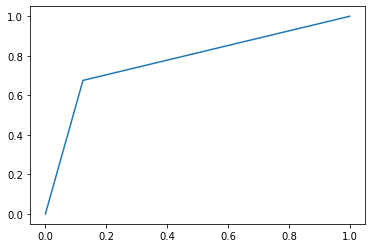

In [76]:
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y, pos_label=1)
plt.plot(fpr, tpr)
plt.show()